In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from tqdm.auto import tqdm

from tabular_policy_maze.maze_env import MazeEnv, MazeEnvWithDistanceReward, plot_maze

from tabular_policy_maze.reinforce import (
                train_reinforce,
                train_reinforce_with_baseline,
                train_reinforce_with_advantage,
                train_reinforce_with_advantage_entropy,
                train_reinforce_with_gae_entropy,
            )

from tabular_policy_maze.util import (
                plot_maze_with_trajectory,
                plot_steps_distribution,
                build_maze_env,
                benchmark,
                create_gif,
            )

In [137]:
env = build_maze_env(
    MazeEnv,
    size=12,
    obstacle_pct=0.25,
    seed=50,
    max_steps=300
)

print(f"States: {env.n_states}, Actions: {env.n_actions}")

States: 113, Actions: 4


In [138]:
theta_tmp, mean_ret_tmp = train_reinforce_with_advantage_entropy(
    env, n_iter=100, n_episodes=512, alpha=1, gamma=1, alpha_v=0.1, entropy_beta=0.05
)

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

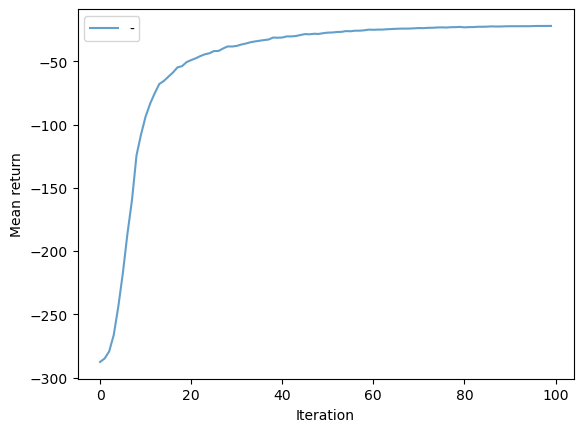

In [ ]:
plt.plot(mean_ret_tmp, label='-', alpha=0.7)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Mean return")
plt.show()

In [148]:
pos, reached_goal = create_gif(theta_tmp, env, output_path="maze_walk.gif", last_frame_hold=3)

In [10]:
base_train_args = {
    'n_iter': 100,
    'n_episodes': 256,
    'alpha': 0.05,
    'gamma': 1.0,
}

# theta_1, mean_ret_1 = train_reinforce(env, **base_train_args)
theta_2, mean_ret_2 = train_reinforce_with_baseline(env, **base_train_args, alpha_v=0.05)
theta_3, mean_ret_3 = train_reinforce_with_advantage(
    env, n_iter=100, n_episodes=512, alpha=1, gamma=1, alpha_v=0.05
)
theta_4, mean_ret_4 = train_reinforce_with_advantage_entropy(
    env, n_iter=100, n_episodes=512, alpha=1, gamma=1, alpha_v=0.05, entropy_beta=0.1
)

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
theta_5, mean_ret_5 = train_reinforce_with_gae_entropy(
    env, n_iter=100, n_episodes=256, alpha=1, gamma=1, lam=0.95, entropy_beta=0.01
)

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

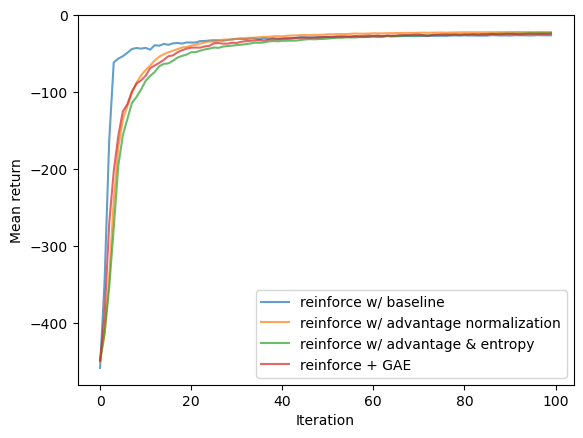

In [20]:
# plt.plot(mean_ret_1, label='reinforce', alpha=0.7)
plt.plot(mean_ret_2, label='reinforce w/ baseline', alpha=0.7)
plt.plot(mean_ret_3, label='reinforce w/ advantage normalization', alpha=0.7)
plt.plot(mean_ret_4, label='reinforce w/ advantage & entropy', alpha=0.7)
plt.plot(mean_ret_5, label='reinforce + GAE', alpha=0.7)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Mean return")
# plt.yscale('log')
plt.show()

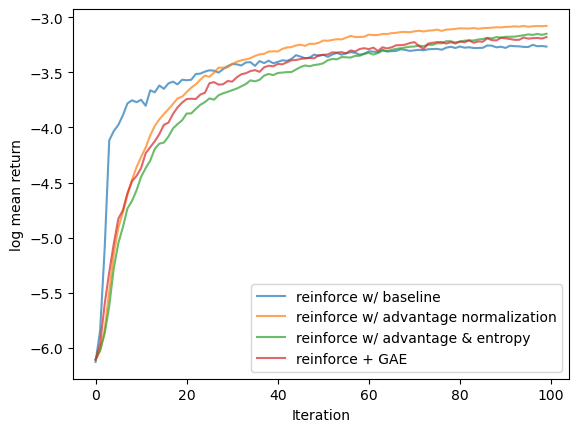

In [21]:
# plt.plot(mean_ret_1, label='reinforce', alpha=0.7)
plt.plot(-np.log(-np.array(mean_ret_2)), label='reinforce w/ baseline', alpha=0.7)
plt.plot(-np.log(-np.array(mean_ret_3)), label='reinforce w/ advantage normalization', alpha=0.7)
plt.plot(-np.log(-np.array(mean_ret_4)), label='reinforce w/ advantage & entropy', alpha=0.7)
plt.plot(-np.log(-np.array(mean_ret_5)), label='reinforce + GAE', alpha=0.7)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("log mean return")
# plt.yscale('log')
plt.show()

## Success rate vs batch size

In [97]:
reinforce_args = {
    'n_iter': 100,
    'alpha': 0.05,
    'gamma': 1.0,
}

reinforce_with_baseline_args = {
    'n_iter': 100,
    'alpha': 0.05,
    'gamma': 1.0,
    'alpha_v': 0.05,
}

reinforce_with_advantage_args = {
    'n_iter': 100,
    'alpha': 1.0,
    'gamma': 1.0,
    'alpha_v': 0.05,
}

reinforce_with_advantage_entropy_args = {
    'n_iter': 100,
    'alpha': 1.0,
    'gamma': 1.0,
    'alpha_v': 0.05,
    'entropy_beta': 0.005
}

reinforce_with_gae_args = {
    'n_iter': 100,
    'alpha': 1.0,
    'gamma': 1.0,
    'lam': 0.95,
    'entropy_beta': 0.005
}

maze_args = {
    'size': 12,
    'obstacle_pct': 0.25,
    'max_steps': 300,
    'step_reward': -1.0,
    'goal_reward': 0.0, 
}

n_episodes_arr = [8, 32, 128, 512]

methods = [
    {
        "method_name": "reinforce",
        "train_function": train_reinforce,
        "args": reinforce_args
    },
    {
        "method_name": "reinforce_with_baseline",
        "train_function": train_reinforce_with_baseline,
        "args": reinforce_with_baseline_args
    },
    {
        "method_name": "reinforce_with_advantage",
        "train_function": train_reinforce_with_advantage,
        "args": reinforce_with_advantage_args
    },
    {
        "method_name": "reinforce_with_advantage_entropy",
        "train_function": train_reinforce_with_advantage_entropy,
        "args": reinforce_with_advantage_entropy_args
    },
    {
        "method_name": "reinforce_with_gae",
        "train_function": train_reinforce_with_gae_entropy,
        "args": reinforce_with_gae_args
    }
]

In [93]:
n_seeds = 4
n_eval = 200

In [94]:
results = []

for i, d in enumerate(methods):
    print(f"Method: {d['method_name']}")
    results_for_method = {}
    results_for_method["method_name"] = d["method_name"]
    results_for_method["args"] = d["args"]
    results_for_method["n_episodes_arr"] = []
    results_for_method["success_rate_arr"] = []
    results_for_method["mean_steps_arr"] = []
    for n_episodes in tqdm(n_episodes_arr):
        train_arguments = d["args"].copy()
        train_arguments.update({"n_episodes": n_episodes})

        summary = benchmark(
            train_method=d["train_function"],
            train_arguments=train_arguments,
            maze_class=MazeEnv,
            maze_arguments=maze_args,
            n_seeds=n_seeds,
            n_eval=n_eval
        )

        results_for_method['n_episodes_arr'].append(n_episodes)
        results_for_method['success_rate_arr'].append(summary["avg_success_rate"])
        results_for_method['mean_steps_arr'].append(summary["avg_steps"])

    with open(f"res_{d['method_name']}.json", "w", encoding="utf-8") as f:
        json.dump(results_for_method, f)
    
    results.append(results_for_method)

Method: reinforce_with_gae


  0%|          | 0/4 [00:00<?, ?it/s]

Seeds:   0%|          | 0/4 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]


Maze 12x12, obstacles=25%, seeds=4
Success rate: 50.5% ± 49.5%
Mean steps (goal only): 60.6 ± 49.1


Seeds:   0%|          | 0/4 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]


Maze 12x12, obstacles=25%, seeds=4
Success rate: 100.0% ± 0.0%
Mean steps (goal only): 24.8 ± 1.0


Seeds:   0%|          | 0/4 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]


Maze 12x12, obstacles=25%, seeds=4
Success rate: 100.0% ± 0.0%
Mean steps (goal only): 25.2 ± 0.9


Seeds:   0%|          | 0/4 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE+GAE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]


Maze 12x12, obstacles=25%, seeds=4
Success rate: 100.0% ± 0.0%
Mean steps (goal only): 25.4 ± 1.2


In [121]:
methods_names_list = [
    "reinforce",
    "reinforce_with_baseline",
    "reinforce_with_advantage",
    "reinforce_with_advantage_entropy",
    ]

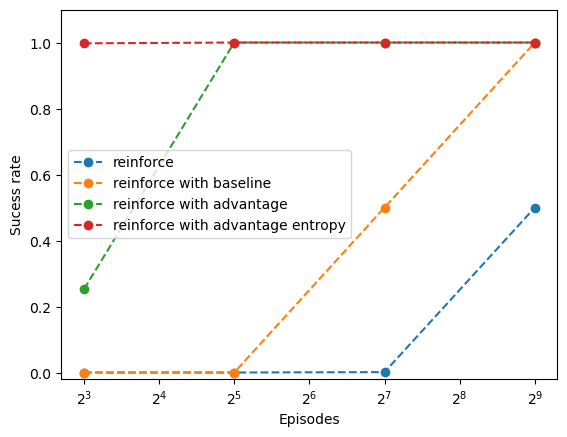

In [ ]:
for i, method_name in enumerate(methods_names_list):
    with open(f"results/res_{method_name}.json", encoding="utf-8") as f:
        results_read = json.load(f)

    n_episodes_arr = np.asarray(results_read["n_episodes_arr"])
    success_rate_arr = np.asarray(results_read["success_rate_arr"])

    method_name_plot = " ".join(method_name.split("_"))

    plt.plot(n_episodes_arr, success_rate_arr, marker='o', ls='--', label=method_name_plot)

plt.legend(loc='center left')
plt.xlabel("Episodes")
plt.xscale('log', base=2)
plt.ylabel("Success rate")
plt.ylim([-0.02, 1.1])
plt.show()

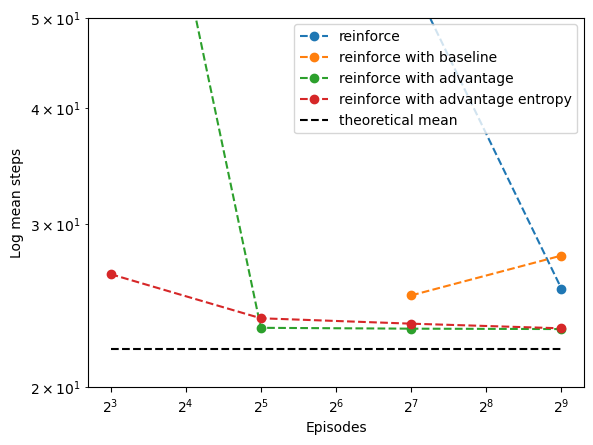

In [ ]:
for i, method_name in enumerate(methods_names_list):

    with open(f"results/res_{method_name}.json", encoding="utf-8") as f:
        results_read = json.load(f)

    n_episodes_arr = np.asarray(results_read["n_episodes_arr"])
    mean_steps_arr = np.asarray(results_read["mean_steps_arr"])

    method_name_plot = " ".join(method_name.split("_"))

    plt.plot(n_episodes_arr, mean_steps_arr, marker='o', ls='--', label=method_name_plot)


plt.hlines(22, 8, 2**9, ls='--', color='k', label="theoretical mean")
plt.legend()
plt.xlabel("Episodes")
plt.xscale('log', base=2)
plt.ylabel("Log mean steps")
plt.yscale('log')
plt.ylim([20, 50])
plt.show()